# framework RACC

Ce framework a pour objectif de mettre en place une estimation de la pluie à partir de données MO (SSMIS) et IR (Meteosat)
Les changements à faire dans le code sont marqués par le mot clé TODO

## imports

In [9]:
# reloading 
%load_ext autoreload
%autoreload 2

# importing librairies
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import pytz
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import interp1d, Rbf
from scipy.optimize import curve_fit
import random

import json
import sys
import os

# importing modules from pluie directory
from classification import classification
import ground_truth_rain as gt

# importing modules from Images
sys.path.insert(0, r'../Images')
from Image import Image,compute_var
from File import File
from Geotiff_Format import Geotiff_Format

# importing modules from tools
sys.path.insert(0, r'../tools')
from tools import get_index,save_index,make_directory

# importing meteosat API modules
sys.path.insert(0, r'API_meteosat')
from eds_get_nearest import search_nearest,download_dataset
sys.path.insert(0, r'API_nsidc')
from SSMIS_download import download_SSMIS_image
sys.path.insert(0, r'API_IMERG')
from IMERG_download import download_IMERG_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialisation des variables principales

On définit les chemins d'accès principaux afin d'obtenir les variables utiles dans tout le code

In [2]:
# TODO : remplir le chemin d'accès au dossier principal où tous les fichiers seront générés
main_dir = make_directory(r"../../data/RACC/2020")

# TODO : remplir le chemin d'accès au fichier json contenant les dates et leurs différents attributs
index_path = main_dir + r"/acq_dates.json"

# TODO : remplir le chemin d'accès au fichier json contenant les paramètres de la projection comme la résolution et l'emprise
projection_path = r"../../data/param_proj/param_guy.json"

# TODO : remplir le chemin d'accès aux fichiers csv contenant la vérité terrain
gt_fn = r"../../data/pluie_sol/gg_2020_1h.csv"

# TODO : compléter les dates visées dans le format suivant

target_dates = [
    "2020-05-03T12:00:00.000000+0000",
    "2020-05-08T12:00:00.000000+0000",
    "2020-05-11T12:00:00.000000+0000",
    "2020-05-15T12:00:00.000000+0000",
    "2020-05-18T12:00:00.000000+0000",
    "2020-05-24T12:00:00.000000+0000",
    "2020-05-26T12:00:00.000000+0000",
    "2020-05-29T12:00:00.000000+0000",
    "2020-12-01T20:00:00.000000+0000",
    "2020-12-12T12:00:00.000000+0000",
    "2020-12-20T06:00:00.000000+0000",
    "2020-12-29T12:00:00.000000+0000"
]

# TODO : remplir le chemin d'accès aux fichierx contenant les clés des API
path_API_meteosat_keys = r"../../data/keys/eds.key"
path_API_nsidc_keys = r"../../data/keys/mdp_NSIDC.json"

# TODO : remplir le chemin d'accès aux dossiers où seront téléchargés les fichiers bruts (ces fichiers peuvent être lourd)
SSMIS_src_dir = make_directory(r"../../data/SSMIS/2020")
SEVIRI_src_dir = make_directory(r"../../data/SEVIRI/2020")
IMERG_src_dir = make_directory(r"../../data/IMERG/2020")

###########################################

SSMIS_proj_dir = make_directory(main_dir + r"/SSMIS")
SEVIRI_proj_dir = make_directory(main_dir + r"/SEVIRI")
rr_dir = make_directory(main_dir + r"/rain_rate")
agr_dir = make_directory(main_dir + r"/agregation")
seg_dir = make_directory(main_dir + r"/classification")

projection = json.load(open(projection_path, "r", encoding="utf-8"))
format = "%Y-%m-%dT%H:%M:%S.%f%z"

SSMIS_parameters = { # permet de rechercher les images SSMIS par itération sur des paramètres de moins en moins pertinents
        "freq":     ["91V",         "91V",          "91V",          "91V"       ],
        "passage":  ["E",           "A",            "E",            "A"         ],
        "capteur":  ["F17_SSMIS",   "F17_SSMIS",    "F16_SSMIS",    "F16_SSMIS" ],
        "algo":     ["GRD",         "GRD",          "GRD",          "GRD"       ],
        "grid":     ["N25km",       "N25km",        "N25km",        "N25km"     ]
        }

index = {d.split(" ")[0]:{"target":d} for d in target_dates}
#save_index(index,index_path)   # peut supprimer un fichier courant

## Extraction des images SSMIS 

In [18]:
def download_SSMIS(attribute):
    """
    Télécharge les données SSMIS, puis réalise leur extraction et leur projection
    Un fichier déjà présent dans le dossier SSMIS_src_dir n'est pas téléchargé à nouveau
    La recherche se fait par itérations sur les paramètres de SSMIS_parameters
    
    Args:
        attribute (string) : attribut à extraire de l'image
    """
    index = get_index(index_path)
    for d in index.keys():
        # téléchargement des données
        tg_date = datetime.strptime(d,format)
        retour = download_SSMIS_image(tg_date,SSMIS_src_dir,projection,SSMIS_parameters,path_API_nsidc_keys)
        tg_freq = SSMIS_parameters["freq"][0]
        if retour: # un fichier a bien été téléchargé
            src_filename,start_date,end_date = retour
            file = File(src_filename) ; string_d = d[:10]
            tif_filename = SSMIS_proj_dir + rf"/SSMIS_{attribute}_{tg_freq}_{string_d}.tiff"
            file.project(projection,attribute,out_path=tif_filename) # projection
            # inscription des chemins d'accès à l'index
            index[d][f"SSMIS_src_{tg_freq}"] = src_filename
            index[d][f"start_date_{tg_freq}"] = datetime.strftime(start_date,format)
            index[d][f"end_date_{tg_freq}"] = datetime.strftime(end_date,format)
            index[d][f"SSMIS_tif_{tg_freq}"] = tif_filename
            save_index(index,index_path)
        else:
            print(f"aucun fichier n'a été trouvé pour la date {d}")
        

In [ ]:
download_SSMIS("TB")

## Extraction des images SEVIRI

In [11]:
def download_SEVIRI_image(d,src_dir,keys_filename):
    try:
        zipped_dir,unzipped_dir = make_directory(src_dir+r"/zipped"),make_directory(src_dir+r"/unzipped")
        prod, Meteosat_date = search_nearest(d)
        filename = fr"{unzipped_dir}/{prod}.nat"
        if os.path.exists(filename):
            print(f"le fichier {filename} a déjà été téléchargé")
        else:
            download_dataset([prod],zipped_dir,unzipped_dir,keys_filename)
        start_date,end_date = File(filename).getAcqDates()
        return filename, start_date, end_date
    except:
        print(f"le fichier pour la date {d} n'as pas été téléchargé")
        return False
        


def download_SEVIRI(attribute):
    """
    Télécharge les données SEVIRI, puis réalise leur extraction et leur projection
    Un fichier déjà présent dans le dossier SEVIRI_src_dir n'est pas téléchargé à nouveau
    
    Args:
        attribute (string) : attribut à extraire de l'image
        SEVIRI_parameters (dict) : dictionnaire contenant les paramètres successifs à prendre en compte dans le téléchargement
    """
    nb_files_per_period = 12
    index = get_index(index_path)
    arrays_SEVIRI = []
    for d in index.keys():
        index[d]["IR_SEVIRI_source_files"] = []
        print(f"recherche pour la date {d}")
        start_acq_date = datetime.strptime(index[d]["start_date_91V"],format)
        end_acq_date = datetime.strptime(index[d]["end_date_91V"],format)
        delta = timedelta(seconds=(end_acq_date - start_acq_date).total_seconds() / nb_files_per_period)
        researched_dates = [start_acq_date + i*delta for i in range(nb_files_per_period)]
        for res_d in researched_dates:
            # téléchargement des données
            retour = download_SEVIRI_image(res_d,SEVIRI_src_dir,path_API_meteosat_keys)
            if retour: # un fichier a bien été téléchargé
                src_filename,start_date,end_date = retour
                index[d]["IR_SEVIRI_source_files"] = index[d]["IR_SEVIRI_source_files"] + [src_filename]
                SEVIRI_file = File(src_filename)
                img_proj = SEVIRI_file.project(projection,attribute)
                arrays_SEVIRI.append(img_proj.array)
        img_proj_agreg = Image(np.mean(np.array(arrays_SEVIRI),axis=0),img_proj.lons,img_proj.lats)
        string_d = d[:10]
        tif_filename = SEVIRI_proj_dir + rf"/SEVIRI_TB_{attribute}_{string_d}.tiff"
        img_proj_agreg.save(projection,tif_filename)
        index[d][f"SEVIRI_tif_{attribute}"] = tif_filename
        save_index(index,index_path)

In [ ]:
download_SEVIRI("IR_108")

## Relation images - vérité terrain

In [3]:
def prepare_corr_from_index(key,attribute=1,start_date_key="start_date",end_date_key="end_date",format="%Y-%m-%dT%H:%M:%S.%f%z"):
    index = get_index(index_path)
    # initialisation des listes contenant les données
    pixel_values,true_rain,locations = [],[],[]
    for d in index.keys():
        try:
            file = File(index[d][key])
            img = file.project(projection,attribute)
            start_date = datetime.strptime(index[d][start_date_key],format)
            end_date = datetime.strptime(index[d][end_date_key],format)
            (tr_smpl,pv_smpl,loc_smpl) = combine_image_with_GT(img,start_date,end_date)
            true_rain.extend(tr_smpl) ; pixel_values.extend(pv_smpl) ; locations.extend(loc_smpl)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    return true_rain,pixel_values,locations

def combine_image_with_GT(image,start_date,end_date):
    # initialisation des listes en retour
    true_rain_sample, pixel_values_sample,locations_sample = [],[],[]
    # récupération de la vérité terrain et agrégation
    gt_dict = gt.csv2dict(gt_fn,quiet=True)[0]
    path_metadata_GT = os.path.dirname(gt_fn) + r"/gauges_guyane_metadata.csv"
    metadata_gt = gt.get_metadata(path_metadata_GT)
    gt_extr_dict = gt.extract(gt_dict,start_date,end_date)
    gt_agr_dict = gt.agreg(gt_extr_dict,method="mean")
    agr_gt = np.array([gt_agr_dict[d] for d in gt_agr_dict.keys()])
    for k in metadata_gt.keys(): # pour chaque station on associe la valeur du pixel à l'agrégation des mesures sur la période d'acquisition
        lat, lon = float(metadata_gt[k]["lat"]),float(metadata_gt[k]["lon"])
        lats, lons = image.lats.T[0], image.lons[0]
        idx_lat,idx_lon = (np.abs(lats - lat)).argmin(), (np.abs(lons - lon)).argmin()
        pixel_value = image.array[idx_lat][idx_lon] ; true_rain_value = agr_gt[0][k-1]
        if (not np.isnan(true_rain_value)) and (not np.isnan(pixel_value)):
            true_rain_sample.append(true_rain_value)
            pixel_values_sample.append(pixel_value)
            locations_sample.append(metadata_gt[k]["Nom"])
        else:
            print(f"valeur nulle rencontrée : gt = {true_rain_value} - pixel = {pixel_value}")
    return (true_rain_sample,pixel_values_sample,locations_sample)
            

## Agrégation des données

In [96]:
def agregation_geotiff(out_dir,key,mode="mean",compute_var=False):
    arrays = []
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            file = File(index[d][key])
            if file.format != Geotiff_Format:
                print("le fichier doit être en format Geotiff")
                raise
            img = file.getImage(1)
            arrays.append(img.array)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    
    lons,lats = img.lons, img.lats
    if mode == "mean":
        output = np.nanmean(np.array(arrays),axis=0)
    else:
        output = np.sum(np.array(arrays),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_dir + rf"/{key}_agreg.tiff")
    if compute_var:
        img_output_var = img_output.computeVar()
        img_output_var.save(projection,out_dir + rf"/{key}_agreg_var.tiff")


In [98]:
key = "SSMIS_tif_91V" ; var = False
#key = "SEVIRI_IR_108_tif" ; var = True
#key = "rain_rate" ; var = False
agregation_geotiff(agr_dir,key,compute_var=var)

## Modélisation pluviométrie

### à partir des images SSMIS seulement

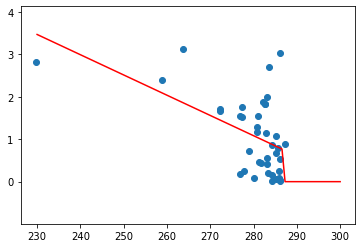

In [7]:
def f_model_MO(array,*args):
    if len(args)==1:
        params = args[0]
        [x_lim,a,b] = params
    elif len(args)==3:
        x_lim,a,b = args
    return np.where(array>x_lim,0,a*array+b)

def fit_model_MO(key,period_keys,plot=True):
    (sdk,edk) = period_keys
    rain_gt,val_images,locations = prepare_corr_from_index(key,end_date_key=edk,start_date_key=sdk)
    xdata,ydata = [],[]
    for i in range(len(rain_gt)):
        if (not np.isnan(val_images[i])) and (not np.isnan(rain_gt[i])) :
            xdata.append(val_images[i]) ; ydata.append(rain_gt[i])
    xlim = np.max(xdata)
    a = (xdata[0]-xdata[1])/(ydata[0]-ydata[1])
    b = ydata[0] - a*xdata[0]
    param_opt, pcov = curve_fit(f=f_model_MO,xdata=xdata,ydata=ydata,p0=(xlim,a,b))
    if plot:
        xsample = np.linspace(230, 300, 100)
        ysample = [f_model_MO(xsample[i],param_opt) for i in range(len(xsample))]

        plt.plot(xsample,ysample,color="red")
        plt.scatter(xdata,ydata)
        plt.ylim(ymin=np.min(ydata)-1,ymax=np.max(ydata)+1)
        plt.show()
    return param_opt

key = "SSMIS_tif_91V" ; period_keys = ("start_date_91V","end_date_91V")
param_opt = fit_model_MO(key,period_keys)

### à partir de la méthode RACC

In [9]:
def fit_model_RACC(N,model_param,agr_dir,seg_dir):
    array_pred,centers,legend = classification(agr_dir,seg_dir,projection,N=N,standardisation=True,epsilon=0.001,T=100,save=False,show=False)
    new_centers = np.zeros(np.shape(centers))
    idx_MO = np.argmax([("SSMIS" in leg) for leg in legend])
    idx_var = np.argmax([("var" in leg) for leg in legend])
    idx_IR = [i for i in range(len(legend)) if i not in [idx_var,idx_MO]][0]
    new_centers[:, 0] = centers[:, idx_IR]
    new_centers[:, 1] = centers[:, idx_var]
    new_centers[:, 2] = f_model_MO(centers.T[idx_MO],model_param)
    centers_fn = seg_dir+"/centers.npy"
    np.save(centers_fn,new_centers)
    return new_centers

def f_model_RACC(array,centers):
    array_var = compute_var(array)
    (nb_rows,nb_cols) = np.shape(array)
    rain_pred = np.zeros((nb_rows,nb_cols))
    for y in range(nb_rows):
        for x in range(nb_cols):
            c = np.argmin(np.sqrt((centers.T[0]-array[y][x])**2+(centers.T[1]-array_var[y][x])**2))
            rain_pred[y][x] = centers[c][2]
    return rain_pred

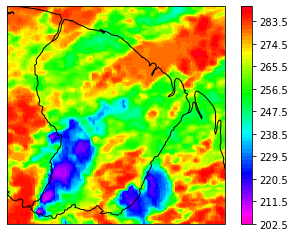

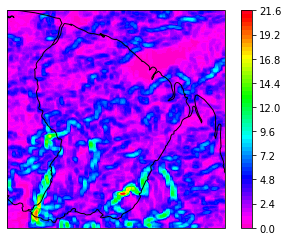

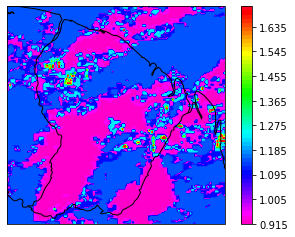

In [10]:
N = 20 ; key="SSMIS_tif_91V" ; 
param_opt = fit_model_MO(key,period_keys,plot=False)
centers = fit_model_RACC(N,param_opt,agr_dir,seg_dir)

fn = r"C:\Users\Baptiste\Documents\ENSG\stage\data\SEVIRI\MSG4-SEVI-MSG15-0100-NA-20211230201243.081000000Z-NA.nat"

image = File(fn).project(projection,"IR_087")
image.show()
var = image.computeVar()
var.show()
arr_result = f_model_RACC(image.array,centers)
rain_estim = Image(arr_result,image.lons,image.lats)
rain_estim.show()

### application du modèle

In [ ]:
def compute_rain_rate(key,f_model,params,out_dir=False,show=True):
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            image = File(index[d][key]).getImage(1)
            R = f_model(image.array,params)
            img_rain_rate = Image(R,image.lons,image.lats)
            if out_dir:
                filename = out_dir + rf"/rain_rate_{d[:10]}.tiff"
                img_rain_rate.save(projection,filename)
                index[d]["rain_rate"] = filename
                save_index(index,index_path)
            if show:
                img_rain_rate.show()
        except KeyError:
            print(f"l'un des fichiers correspondant à la date {d} n'a pas été trouvé")

compute_rain_rate("SEVIRI_IR_108_tif",f_model_RACC,centers,rr_dir)

## Corrélation

In [4]:
def correlation(ground_list,estim_list,indice_corr="Pearson",savefig=False):
    ground_list,estim_list = np.array(ground_list),np.array(estim_list)
    xmin,xmax,attributes = 260,290,False

    if indice_corr == "Pearson":
        corr, _ = pearsonr(ground_list, estim_list)
    elif indice_corr == "Spearman":
        corr, _ = spearmanr(ground_list, estim_list)
    RMSE = np.sqrt(np.sum((ground_list-estim_list)**2)/len(ground_list))
    BIAS = np.sum(estim_list-ground_list) / np.sum(ground_list)

    print(f"CC {indice_corr} = {round(corr,3)}")
    print(f"RMSE = {round(RMSE,3)}")
    print(f"BIAS = {round(BIAS,3)}")



    if attributes:
        color_list = ["red","green","blue","orange","yellow","pink","black","purple","beige","brown","gray","cyan"]
        colors = [color_list[np.where(np.unique(attributes)==loc)[0][0]] for loc in attributes]
        plt.scatter(ground_list,estim_list,c=colors,s=60, alpha=0.8)
        for i in range(len(np.unique(attributes))):
            print(color_list[i],"\t",np.unique(attributes)[i])
    else:
        plt.scatter(ground_list,estim_list,s=50,alpha=0.8)
    plt.grid() # ICI
    plt.title(f"relation entre prédiction et vérité terrain\noct 2020")
    plt.xlabel("pluviométrie moyenne (mm/h)")
    plt.ylabel("pluviométrie estimée IMERG (mm/h)")
    #plt.xlim(xmin=xmin,xmax=xmax)
    if savefig:
        plt.savefig(savefig, dpi=500)
    plt.show()

In [ ]:
savefig = r"../../rapports/images/rel_TBIR097-rain_0520.png"

#SEVIRI_IR_097_tif - SSMIS_tif_91V
key,sdk,edk = "SSMIS_tif_91V","start_date_91V","end_date_91V"
true_rain,estim_rain,locations = prepare_corr_from_index(key,end_date_key=edk,start_date_key=sdk)

correlation(true_rain,estim_rain,indice_corr="Spearman",savefig=False)

## Estimation pluie et validation

In [5]:
def model_evaluation(f_model,param_opt,image_source,start_period,end_period,attribute,nb_values=5,corr="Pearson",savefig=False):
    random.seed(69)
    # générer une date dans la zone d'étude et télécharger l'image correspondante
    true_rain,pixel_values,locations = [],[],[]
    
    for i in range(nb_values):
        delta_sec = random.randint(1,int((end_period-start_period).total_seconds()))
        d = start_period + timedelta(seconds=delta_sec)
        if image_source == "SEVIRI":
            result = download_SEVIRI_image(d,SEVIRI_src_dir,path_API_meteosat_keys)
        elif image_source == "SSMIS":
            result = download_SSMIS_image(d,SSMIS_src_dir,projection,SSMIS_parameters,path_API_nsidc_keys,quiet=False)
        elif image_source == "IMERG":
            result = download_IMERG_image(d,IMERG_src_dir)
        else:
            result = False
        
        if result != False:
            (fn,start,end) = result
            # estimation de la pluie à partir du modèle appliqué à l'image
            image = File(fn).project(projection,attribute)
            R = f_model(image.array,param_opt)
            img_rain_rate = Image(R,image.lons,image.lats)
            #img_rain_rate.show()
            (tr_smpl,pv_smpl,loc_smpl) = combine_image_with_GT(img_rain_rate,start,end)
            true_rain.extend(tr_smpl) ; pixel_values.extend(pv_smpl) ; locations.extend(loc_smpl)
        else :
            print(f"aucune image n'a pu être téléchargée pour la date {d}")
            pass
        

    # évaluer l'estimation
    print(len(true_rain))
    correlation(true_rain,pixel_values,indice_corr=corr,savefig=savefig)
    

In [7]:
m = 10 # ICI
start_period = datetime(year=2020,month=m,day=1,tzinfo=pytz.UTC)
end_period = datetime(year=2020,month=m,day=31,tzinfo=pytz.UTC)

### évaluation modèle MO

In [ ]:
# mise en place d'un modèle de calcul de pluie et évaluation
key = "SSMIS_tif_91V" ; period_keys = ("start_date_91V","end_date_91V")
param_opt = fit_model_MO(key,period_keys,plot=False)
model_evaluation(f_model_MO,param_opt,"SSMIS",start_period,end_period,"TB")

### évaluation modèle RACC

In [ ]:
N = 20 ; key="SSMIS_tif_91V" ; 
param_opt = fit_model_MO(key,period_keys,plot=False)
centers = fit_model_RACC(N,param_opt,agr_dir,seg_dir)
model_evaluation(f_model_RACC,centers,"SEVIRI",start_period,end_period,"IR_108")

### relation TB - pluie 

In [ ]:
def f_(a,param):
    return a
param = None

savefig = r"../../rapports/images/cor_TBMO-VT_2020_oct.png" 
model_evaluation(f_,param,"SSMIS",start_period,end_period,"TB",corr="Spearman",nb_values=15,savefig=savefig)

In [ ]:
def f_(a,param):
    return a
param = None

savefig = r"../../rapports/images/cor_IMER-VT_2020_oct.png" # ICI
model_evaluation(f_,param,"IMERG",start_period,end_period,"HQprecipitation",corr="Pearson",nb_values=15,savefig=False)